In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
import pandas as pd
import os
import tempfile

In [44]:
# Constants
SKETCHY_PATH = "~/sketchy"
SKETCHY_DATABASE_PATH = "~/sketchy-database"

**Issues:**
1. stats.csv "Category" contains names with spaces, however database directory names don't contain space but underscore.
2. testset.txt image extension is JPEG, whereas the database uses PNG

## Data preparation
### Train test split

In [58]:
class SketchyDatabase(object):
    
    DefaultSketchAugmentation = 4
    SketchAugmentations = ["tx_000000000000", "tx_000000000010", "tx_000000000110", 
                       "tx_000000001010",  "tx_000000001110",  "tx_000100000000"]

    def __init__(self, database_root, augmentation=None, verbose=False):
        
        self.database_root = os.path.expanduser(database_root)
        
        if not augmentation:
            augmentation = SketchyDatabase.SketchAugmentations[SketchyDatabase.DefaultSketchAugmentation]
            
        self.augmentation = augmentation
        self.sketch_img_path = os.path.join(self.database_root, "rendered_256x256/256x256/sketch", self.augmentation)
        self.verbose= verbose
        self.__read_data()
        
        if verbose:
            print "Number of sketches: {0}".format(len(sketchy_database.sketch_stats_df))
            print "Number of image objects: {0}".format(len(sketchy_database.sketch_stats_df['ImageNetID'].unique()))
            print "Number of sketch classes: {0}".format(self.sketch_num_classes)
        
    def __read_data(self):
        
        # read sketch data
        self.sketch_stats_df = pd.read_csv(os.path.join(self.database_root, "info/stats.csv"))
        
        # Fix "Category" name (See above: issue no. 1)
        self.sketch_stats_df["Category"] = self.sketch_stats_df["Category"].apply(lambda x: x.replace(" ", "_"))
        
        self.sketch_invalid_ambiguous_df = pd.read_csv(
                    os.path.join(self.database_root, "info/invalid-ambiguous.txt"), header=None)
        self.sketch_invalid_context_df = pd.read_csv(
                    os.path.join(self.database_root, "info/invalid-context.txt"), header=None)
        self.sketch_invalid_error_df = pd.read_csv(
                    os.path.join(self.database_root, "info/invalid-error.txt"), header=None)
        self.sketch_invalid_pose_df = pd.read_csv(
                    os.path.join(self.database_root, "info/invalid-pose.txt"), header=None)
        self.sketch_testset_df = pd.read_csv(
                    os.path.join(self.database_root, "info/testset.txt"), header=None)
        
        # Add new column for convenience
        # Sketch image file name = <ImageNetID>-<SketchID>."png"
        self.sketch_stats_df["_img_file_name"] = self.sketch_stats_df["ImageNetID"] \
                    + "-" + self.sketch_stats_df["SketchID"].map(str)
            
        self.sketch_stats_df["_img_file_path"] = self.sketch_stats_df.apply(
                lambda row: os.path.expanduser(
                                os.path.join(os.path.join(self.sketch_img_path, row["Category"]),
                                            row["_img_file_name"] + ".png")
                            )
            , axis=1)
        
        self.sketch_labels = self.sketch_stats_df["Category"].unique().copy()
        self.sketch_labels.sort()
        self.sketch_num_classes = len(self.sketch_labels)
        
        # read image data
        # ... TODO
        
    def generate_train_test_split(self, shuffle=True, with_ambiguous=False, with_context=False, 
                                                  with_error=False, with_pose=False):
        
        self.__read_data()
        sketch_df = self.sketch_stats_df # shallow copy

        if not with_ambiguous:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_ambiguous_df[0])]
        if not with_context:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_context_df[0])]
        if not with_error:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_error_df[0])]
        if not with_pose:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_pose_df[0])]

        # Databse images are in png format, but testset lists them as jpg, 
        # just blending in with the inconsistency for now (See above: issue no. 2)
        is_test_sample = sketch_df["ImageNetID"].isin(self.sketch_testset_df[0].apply(
                                            lambda x: x.split("/")[1].split('.jpg')[0]))
        sketch_df["_split"] = "train"
        sketch_df["_split"].loc[is_test_sample] = "test"
        
        if shuffle:
            sketch_df = sketch_df.reindex(np.random.permutation(sketch_df.index))
            
        self.sketch_stats_df = sketch_df
        
    def get_caffeinated_dataset(self, split="train"):
        
        assert(split=="train" or split=="test")
        
        sketch_stats_filtered_df = self.sketch_stats_df[self.sketch_stats_df["_split"]==split]
        with tempfile.NamedTemporaryFile(delete=False) as f:
            for _,row in sketch_stats_filtered_df.iterrows():
                f.write(row["_img_file_path"] + " " + str(row["CategoryID"]) + "\n")
        return f.name

In [59]:
sketchy_database = SketchyDatabase(SKETCHY_DATABASE_PATH, verbose=True)
sketchy_database.generate_train_test_split(shuffle=False, with_ambiguous=True, with_context=True, with_error=True, with_pose=True)

Number of sketches: 75481
Number of image objects: 12500
Number of sketch classes: 125


## Data Exploration

In [60]:
if 'sketchy_database' in vars() or 'sketchy_database' in globals():
    del sketchy_database
sketchy_database = SketchyDatabase(SKETCHY_DATABASE_PATH)
sketchy_database.generate_train_test_split(shuffle=True, with_ambiguous=False, with_context=False, with_error=False, with_pose=False)

In [61]:
import matplotlib.gridspec as gridspec

def vis_samples(sketch_df, sketch_img_path, grid_size=(None, None), max_tiles=100):
    
    sketch_df = sketch_df[:max_tiles].copy()
    n_imgs = len(sketch_df)
    n_rows, n_cols = grid_size
    
    if n_rows == None or n_cols == None: 
        n_cols = int(np.ceil(np.sqrt(n_imgs)))
        n_rows = int(np.ceil(1.*n_imgs/n_cols))
    
    gs = gridspec.GridSpec(n_rows, n_cols)    
    for idx, (category, img_file_path) in enumerate(sketch_df[["Category", "_img_file_path"]].values):
        plt.subplot(gs[idx]), plt.axis("off")
        img = plt.imread(img_file_path)
        plt.imshow(img)
        plt.title(category)

Training data samples


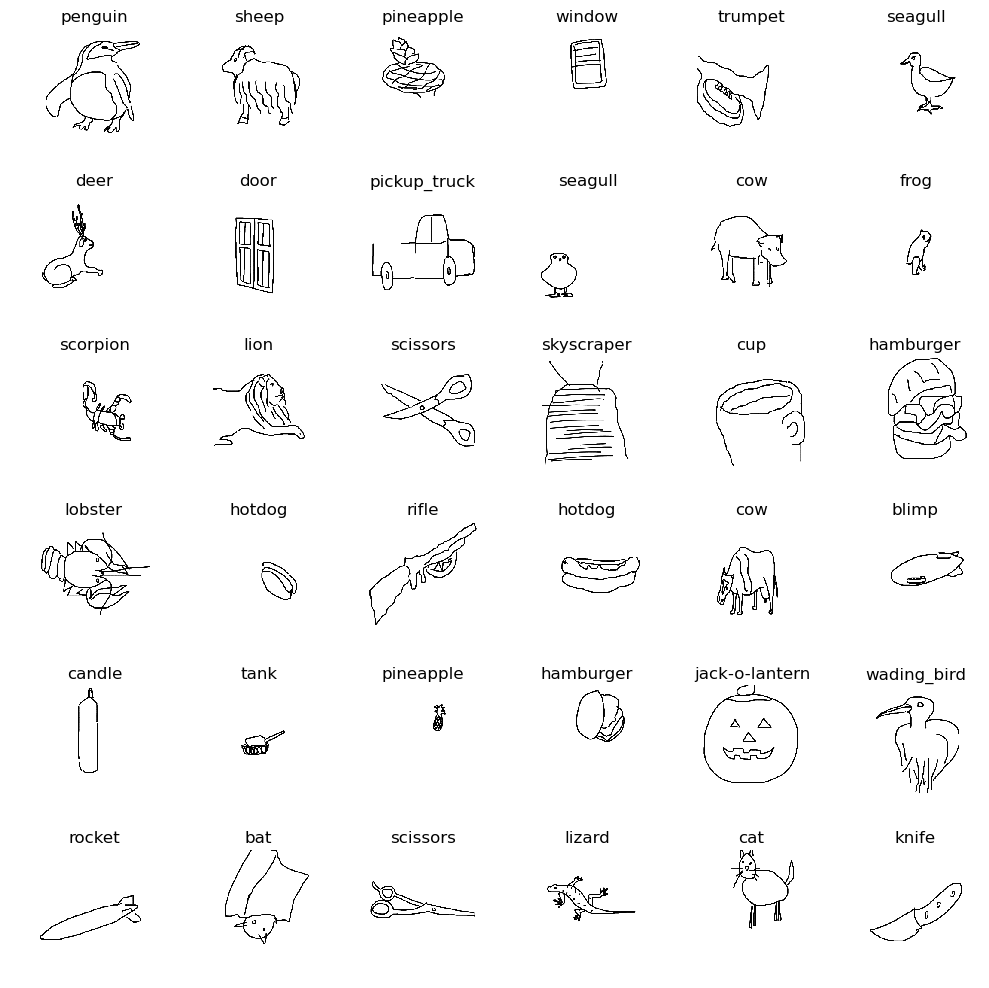

In [62]:
np.random.seed(0)
disp_samples = 36
train_df = sketchy_database.sketch_stats_df[sketchy_database.sketch_stats_df["_split"] == "train"]
# rand_locations = np.random.choice(train_df.index, disp_samples, replace=False)
vis_samples(train_df, sketchy_database.sketch_img_path, max_tiles=disp_samples)
# plt.suptitle("Training data samples")
plt.tight_layout()
print "Training data samples"

Training samples category= airplane


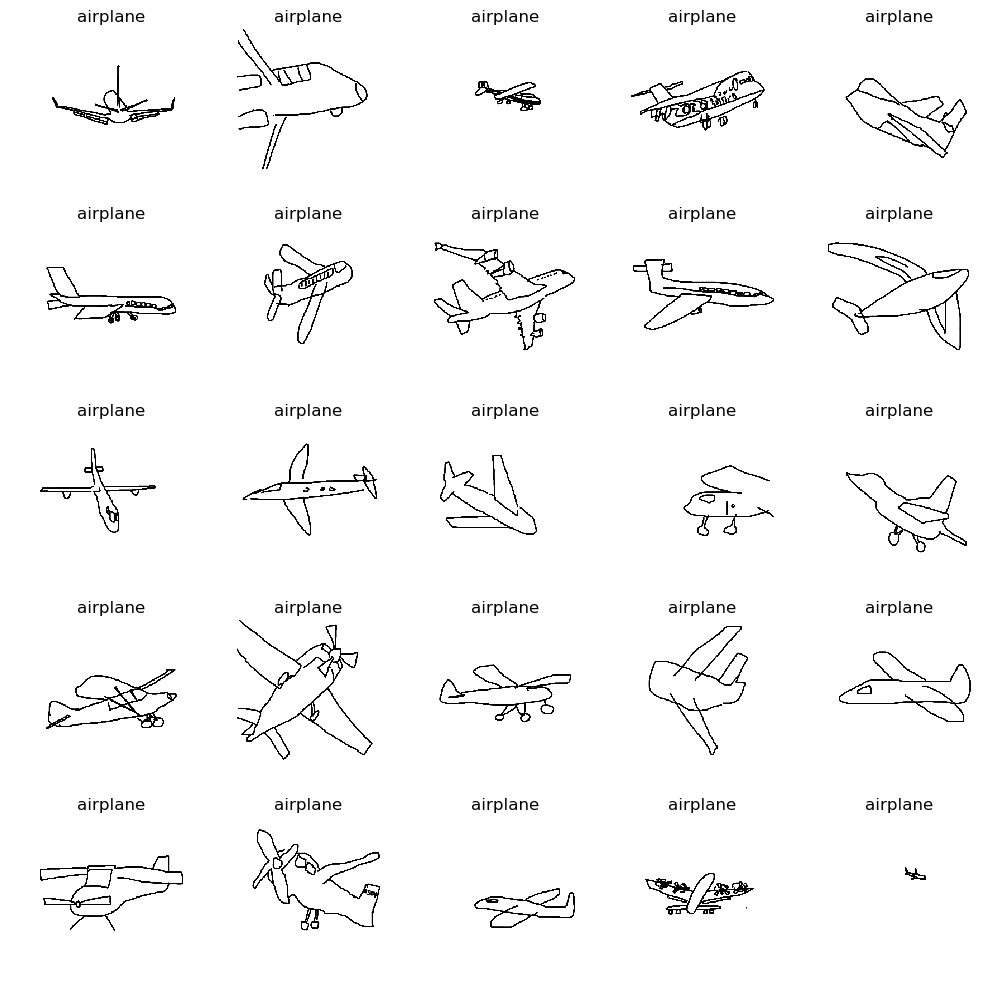

In [63]:
disp_samples = 25
category = "airplane"
train_df = sketchy_database.sketch_stats_df[sketchy_database.sketch_stats_df["_split"] == "train"]
vis_samples(train_df.loc[train_df["Category"] == category], sketchy_database.sketch_img_path, max_tiles=disp_samples)
plt.tight_layout()
print "Training samples category=",category

In [64]:
train_img_list_file = sketchy_database.get_caffeinated_dataset()
test_img_list_file = sketchy_database.get_caffeinated_dataset(split="test")

## Fine-tuning a Pretrained Network for Sketch Recognition

Adapted from: https://github.com/BVLC/caffe/blob/master/examples/02-fine-tuning.ipynb 


In [65]:
caffe_root = os.path.expanduser('~/caffe')  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

# caffe.set_device(0)
# caffe.set_mode_gpu()
caffe.set_mode_cpu()

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [66]:
os.chdir(caffe_root)  # run scripts from caffe root
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet

ImageNet example aux files already exist.
Model already exists.


In [67]:
weights = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(weights)

In [91]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = os.path.join(caffe_root, 'data/ilsvrc12/synset_words.txt')
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...


In [92]:
print 'Sketch labels:\n', ''.join(
                [" {:15}: {:03d} {}".format(label, idx, ("\n" if (idx+1)%5 == 0 else ""))
                        for idx, label in enumerate(sketchy_database.sketch_labels)])

Sketch labels:
 airplane       : 000  alarm_clock    : 001  ant            : 002  ape            : 003  apple          : 004 
 armor          : 005  axe            : 006  banana         : 007  bat            : 008  bear           : 009 
 bee            : 010  beetle         : 011  bell           : 012  bench          : 013  bicycle        : 014 
 blimp          : 015  bread          : 016  butterfly      : 017  cabin          : 018  camel          : 019 
 candle         : 020  cannon         : 021  car_(sedan)    : 022  castle         : 023  cat            : 024 
 chair          : 025  chicken        : 026  church         : 027  couch          : 028  cow            : 029 
 crab           : 030  crocodilian    : 031  cup            : 032  deer           : 033  dog            : 034 
 dolphin        : 035  door           : 036  duck           : 037  elephant       : 038  eyeglasses     : 039 
 fan            : 040  fish           : 041  flower         : 042  frog           : 043  geyser  

### Create Caffe NetSpec and prototxt file

We want to classify sketches. We can train a convolutional neural network on our sketch dataset and run optimization to learn weights that achieve highest accuracy for the classfication. This process works well. But we can do better and save optimization time by exploiting a model that is already trained on millions of images. This is called transfer learning. 

We will be using pretrained weights from the model trained on ImageNet dataset. Images of the Sketch dataset and ImageNet dataset are different; however, the low level feature representations have a lot of similarity. For instance, features such as derivatives, edges, corners, colors, and brightness would play similar role in discriminating classes of both of the datasets. Using pretrained models, we can retain the weights of desired layers, which can ultimately speedup training time.

In general, there are two ways to achieve this.

1. Copy weights from the pretrained model, and re-train all the layers of the new model on new dataset.  
2. Copy weights from the pretrained model, and re-train few of the top layers of the new model on new dataset.

To only learn certain layers (mostly top ones), we set learning rate multiplier (lr_mult) parameter to Caffe layer definition to a non-zero value, conversely we set it to 0 to stop learning (or freeze) certain layers (mostly bottom ones).

Here, first we will experiment with approach 1, that is to initialize weights from pretrained model, and re-train all the layers of the new model.

In [127]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=learned_param) # CHG1: make fc6 param learnable
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=learned_param) # CHG2: make fc7 param learnable
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
#     print label.to_proto()
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

### Define sketch net

In [138]:
def sketch_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = train_img_list_file if train else test_img_list_file
    # set mirror images = False
    transform_param = dict(mirror=False, crop_size=227,
        mean_file=os.path.join(caffe_root,'data/ilsvrc12/imagenet_mean.binaryproto'))
    
    #TODO: Note that future Caffe releases will only support transform_param messages for transformation fields!
    sketch_data, sketch_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=64, new_height=256, new_width=256, ntop=2)
    return caffenet(data=sketch_data, label=sketch_label, train=train,
                    num_classes=SKETCHY_NUM_SKETCH_CLASSES,
                    classifier_name='fc8_sketchy_sketch',
                    learn_all=learn_all)

**Inference test on untrained network**

In [129]:
# Create ImageNet Net
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

# Create Sketch Net
untrained_sketch_net = caffe.Net(sketch_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_sketch_net.forward()
sketch_data_batch = untrained_sketch_net.blobs['data'].data.copy()
sketch_label_batch = np.array(untrained_sketch_net.blobs['label'].data, dtype=np.int32)

In [130]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) cat=%d %5.2f%% %s' % (i+1, p, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image, top_k):
    disp_preds(net, image, imagenet_labels, k=top_k, name='ImageNet')

def disp_sketch_preds(net, image, top_k):
    disp_preds(net, image, sketchy_sketch_labels, k=top_k, name='sketch')

actual label = car_(sedan)


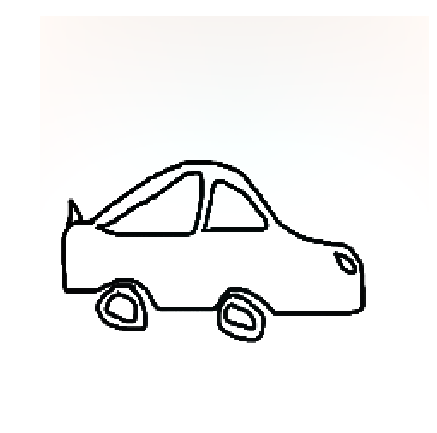

In [131]:
batch_index = 8
image = sketch_data_batch[batch_index]
plt.figure(figsize=(5,5))
plt.imshow(deprocess_net_image(image))
plt.axis("off")
print 'actual label =', sketchy_sketch_labels[sketch_label_batch[batch_index]]

In [119]:
disp_imagenet_preds(imagenet_net, image, 5)

top 5 predicted ImageNet labels =
	(1) cat=600 20.50% n03532672 hook, claw
	(2) cat=772 16.63% n04127249 safety pin
	(3) cat=584 10.99% n03476684 hair slide
	(4) cat=830  9.43% n04336792 stretcher
	(5) cat=823  6.94% n04317175 stethoscope


In [120]:
disp_sketch_preds(untrained_sketch_net, image, 5)

top 5 predicted sketch labels =
	(1) cat=0  0.80% airplane
	(2) cat=90  0.80% scorpion
	(3) cat=89  0.80% scissors
	(4) cat=88  0.80% saxophone
	(5) cat=87  0.80% saw


In [121]:
# Becayse we are using same weights for sketch net, the top layer activations and output shouldn't be much different from imagenet net
diff = untrained_sketch_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

In [132]:
del untrained_sketch_net

## Train sketch classifier

In [133]:
sketchy_models_path = os.path.join(SKETCHY_PATH, "models")
if not os.path.exists(sketchy_models_path):
    os.makedirs(sketchy_models_path)

### Define Solver

In [147]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 500  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'Adam'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = sketchy_models_path + 'sketchy_sketch_clf'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
#     s.solver_mode = caffe_pb2.SolverParameter.GPU
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [148]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

Let's create and run solvers to train nets for the sketch recognition task. We'll create two solvers -- one (sketch_solver) will have its train net initialized to the ImageNet-pretrained weights (this is done by the call to the copy_from method), and the other (scratch_sketch_solver) will start from a randomly initialized net.
During training, we should see that the ImageNet pretrained net is learning faster and attaining better accuracies than the scratch net.

In [ ]:
niter = 10000  # number of iterations to train

# Reset sketch_solver as before.
sketch_solver_filename = solver(sketch_net(train=True, learn_all=True), sketch_net(train=False, learn_all=True), base_lr=1e-4)
# sketch_solver_filename = solver(sketch_net(train=True), sketch_net(train=False), base_lr=1e-4) # With test
sketch_solver = caffe.get_solver(sketch_solver_filename)
# sketch_solver.net.copy_from(weights)
sketch_solver.net.copy_from(weights['pretrained'])

# # For reference, we also create a solver that isn't initialized from
# # the pretrained ImageNet weights.
# scratch_sketch_solver_filename = solver(sketch_net(train=True, learn_all=True), base_lr=1e-4)
# # scratch_sketch_solver_filename = solver(sketch_net(train=True), sketch_net(train=False), base_lr=1e-4) # With test
# scratch_sketch_solver = caffe.get_solver(scratch_sketch_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', sketch_solver)] # , ('scratch', scratch_sketch_solver)
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

# train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
# train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
# sketch_weights, scratch_sketch_weights = weights['pretrained'], weights['scratch']

train_loss, scratch_train_loss = loss['pretrained']
train_acc, scratch_train_acc = acc['pretrained']
sketch_weights, scratch_sketch_weights = weights['pretrained']

# Delete solvers to save memory.
del sketch_solver, scratch_sketch_solver, solvers

Running solvers for 10000 iterations...
  0) pretrained: loss=2.381, acc=39%
 10) pretrained: loss=1.992, acc=50%
 20) pretrained: loss=1.913, acc=52%
 30) pretrained: loss=1.844, acc=47%
 40) pretrained: loss=1.661, acc=56%
 50) pretrained: loss=2.045, acc=48%
 60) pretrained: loss=1.884, acc=48%
 70) pretrained: loss=1.708, acc=56%
 80) pretrained: loss=1.508, acc=58%
 90) pretrained: loss=1.762, acc=53%
100) pretrained: loss=2.037, acc=44%
110) pretrained: loss=2.221, acc=39%
120) pretrained: loss=1.732, acc=50%
130) pretrained: loss=2.023, acc=48%
140) pretrained: loss=1.963, acc=44%
150) pretrained: loss=1.422, acc=62%
160) pretrained: loss=1.857, acc=55%
170) pretrained: loss=1.661, acc=50%
180) pretrained: loss=1.487, acc=53%
190) pretrained: loss=1.664, acc=53%
200) pretrained: loss=1.674, acc=55%
210) pretrained: loss=1.772, acc=50%
220) pretrained: loss=2.185, acc=52%
230) pretrained: loss=1.703, acc=50%
240) pretrained: loss=1.724, acc=58%
250) pretrained: loss=1.621, acc=62

## Match categories with ImageNet for faster training

In [28]:
import pickle
import urllib2

In [29]:
# unpickle dictionary to convert ids to human readable labels
imagenet1000_clsid_to_human = pickle.load(urllib2.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

In [38]:
# imagenet1000_clsid_to_human.values()

In [31]:
imagenet_synset_ids_to_cls_id = {label.split(" ")[0]:idx for idx,label in enumerate(imagenet_labels)}

In [36]:
# imagenet_synset_ids_to_cls_id

In [37]:
# sketchy_database.sketch_stats_df['ImageNetID'].apply(lambda x: x.split("_")[0]).unique()